# SNR (optimal) generation and comparison 

This notebook is a full guide on how to use the `gwsnr` package to generate the 'optimal signal-to-noise ratio' (SNR) and 'probability of detection' (Pdet) for a given Gravitational Wave (GW) signal.

## Contents

1. Introduction to `gwsnr` package
   
2. SNR with bilby inner product
   
3. Interpolation with Partial Scaling method
  
    * Testing speed and accurarcy between the interpolation method and inner product method
    * Pdet calculation
    * Changing the input arguments
   
4. SNR and Pdet with Artificial Neural Network ANN

5. Inner product assisted with JAX 

## 1. Introduction

`gwsnr` is a Python package for calculating the signal-to-noise ratio (SNR) of GW signals. It is designed for detecting GWs from compact binary coalescences (CBCs) with ground-based interferometers. This flexible and user-friendly tool allows users to mix and match different noise models, waveform models, detector configurations, and signal parameters. SNR calculations are enhanced through interpolation techniques and parallel processing.

By default, `gwsnr` uses the interpolation method. The example below generates the SNR for a GW signal from a spin-less binary black hole (BBH) merger with the following parameters: primary mass $m_1 = 30 M_\odot$, secondary mass $m_2 = 30 M_\odot$, and luminosity distance $d_L = 1000 \text{ Mpc}$; while the other parameters are set to their default values.

In [1]:
# loading GWSNR class from the gwsnr package
from gwsnr import GWSNR
import numpy as np

# initializing the GWSNR class with default parameters
gwsnr = GWSNR()

# signal-to-noise ratio for a binary black hole merger with masses 10, 10 Msun at a luminosity distance of 100 Mpc
snrs = gwsnr.snr(mass_1=np.array([30.0]), mass_2=np.array([30.0]), luminosity_distance=np.array([1000.0]))

# print the signal-to-noise ratio
print(snrs)


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  interpolation
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detect

* Results have SNR values of the individual detector and the combined effective SNR value.

### Below shows GWSNR initialization with all of it's (default) arguments

```python
    gwsnr = GWSNR(
        #################################
        # General settings
        npool=4,  # number of processes. Run this to check the number of cores in your machine; import os; os.cpu_count()
        snr_type='interpolation',  # type of SNR calculation. Options are 'interpolation', 'inner_product', 'ann', 'inner_product_jax'
        interpolator_dir='./interpolator_pickle',  # directory to save/load the interpolator
        create_new_interpolator=False,  # if True, it will overwrite the existing interpolator
        gwsnr_verbose=True,  # if True, it will print all gwsnr settings
        multiprocessing_verbose=True, # if True, it will show progress bar for multiprocessing. If False, there will be no progress bar but it will be faster.
        pdet=False,  # if True, it will calculate the probability of detection
        snr_th=8.0,  # threshold SNR for the Pdet for each detector
        snr_th_net=8.0,  # threshold SNR for the Pdet for the network
        ann_path_dict=None,  # path to the ANN model for SNR and Pdet calculation
        #################################
        # Interpolation settings
        # Minimum and maximum values of the parameters for the interpolation grid
        # It is recommended to set minimum and maximum values a bit larger than the expected values to avoid edge effects
        mtot_min=2.0,  # minimum total mass in solar masses
        mtot_max=439.6,  # maximum total mass in solar masses (set to so that there is non zero inspiral length for the waveform)
        ratio_min=0.1,  # minimum mass ratio
        ratio_max=1.0,  # maximum mass ratio
        spin_max=0.9,  # maximum spin magnitude
        # Resolutions of the grid
        # Higher resolution means more accurate results but slower calculations
        mtot_resolution=200,  
        ratio_resolution=50,  
        spin_resolution=20,  # will be used only if snr_type is 'interpolation_aligned_spins'
        #################################
        # Waveform settings
        waveform_approximant='IMRPhenomD',  # frequency domain waveform approximant of the GW signal
        sampling_frequency=2048.0,  # sampling frequency in Hz
        minimum_frequency=20.0,  # minimum frequency of the waveform in Hz
        duration_max=None,  # maximum duration of the waveform in seconds. Bilby default for IMRPhenomXPHM is 64 seconds.
        duration_min=None,  # minimum duration of the waveform in seconds. Bilby default is 4 seconds.
        mtot_cut=True,  # if True, SNR=0 for total mass > mtot_cut
        #################################
        # Detector settings
        psds={'L1':'aLIGO_O4_high_asd.txt','H1':'aLIGO_O4_high_asd.txt', 'V1':'AdV_asd.txt', 'K1':'KAGRA_design_asd.txt'}, # power spectral density of the detectors
        ifos=['L1', 'H1', 'V1'],  # list of detectors. You can also provide bilby interferometer objects.
    )  
```

In [9]:
# # Uncomment and run the following line to see the complete documentation of the GWSNR class
# help(GWSNR)


## 2. SNR with `bilby` inner product

This method is tailored for SNR calculations using frequency domain waveforms as defined in `lalsimulation` (@lalsuite), including spin-precessing binary systems.

- **Methodology**: Combines waveform generation (multi-process), antenna pattern calculation (njit-ted), and noise-weighted inner product computation (njit-ted).

- **Equations**:

  - Noise weighted inner-product of two waveforms $a$ and $b$ ($\tilde{a}$ and $\tilde{b}$ representing frequency domian) is given by: 
  \begin{align}
  \left< a | b \right> = 4 \int_{f_{min}}^{f_{max}} \frac{\tilde{a}(f)\tilde{b}^*(f)}{S_n(f)} df\tag{1}
  \end{align}

  - Optimal SNR using inner-product reads: 
  \begin{align}
  \rho = \sqrt{ F_+^2 \left< \tilde{h}_+ | \tilde{h}_+ \right> + F_{\times}^2 \left< \tilde{h}_{\times} | \tilde{h}_{\times} \right> },\tag{2}
  \end{align}
  for orthogonal $\tilde{h}_+$ and $\tilde{h}_{\times}

  - $\tilde{h}_{+\times}$ are frequency domain waveform polarizations, and $F_{+\times}$ are antenna patterns. 

These formulations highlight `gwsnr`'s capability to efficiently multi-process waveform generation, and enhanced performance using njit-ted inner product computation.

## 2. Noise-Weighted Inner Product Method with Multiprocessing

This method is tailored for SNR calculations using frequency domain waveforms as defined in *`lalsimulation`* (@lalsuite), including spin-precessing binary systems. The gwsnr package optimizes this process by combining multi-process waveform generation with accelerated functions for computing antenna patterns and inner products using `numba.njit`.

`gwsnr` also supports JAX assited inner product, where the waveform generation is facilitated through the `ripple` package (@Edwards:2023sak). Key functions are optimized using `jax.jit` and parallelized with `jax.vmap`.

- **Methodology**: Combines waveform generation (multi-process), antenna pattern calculation (njit-ted), and noise-weighted inner product computation (njit-ted).

- **Equations**:

  - Inner product: $\left< a | b \right> = 4 \int_{f_{min}}^{f_{max}} \frac{\tilde{a}(f)\tilde{b}^*(f)}{S_n(f)} df$

  - Optimal SNR: $\rho = \sqrt{ F_+^2 \left< \tilde{h}_+ | \tilde{h}_+ \right> + F_{\times}^2 \left< \tilde{h}_{\times} | \tilde{h}_{\times} \right> }$, for orthogonal $h_+$ and $h_{\times}$.

  - $h_{+\times}$ are frequency domain waveform polarizations, and $F_{+\times}$ are antenna patterns. 

These formulations highlight *`gwsnr`*'s capability to efficiently generate optimal SNR values without compromising on accuracy, while also providing flexibility in waveform generation and noise modeling.

In [2]:
# loading GWSNR class from the gwsnr package
from gwsnr import GWSNR

# initializing the GWSNR class with inner product as the signal-to-noise ratio type
gwsnr = GWSNR(snr_type='inner_product')

# signal-to-noise ratio for a BBH with GW150914 like parameters with detectors LIGO-Hanford, LIGO-Livingston, and Virgo with O4 observing run sensitivity
snrs = gwsnr.snr(mass_1=np.array([36.0]), mass_2=np.array([29.0]), luminosity_distance=np.array([440.0]), theta_jn=np.array([1.0]), ra=np.array([3.435]), dec=np.array([-0.408]), psi=np.array([0.0]), geocent_time=np.array([1126259462.4]))
print(snrs)


Initializing GWSNR class...

psds not given. Choosing bilby's default psds

Chosen GWSNR initialization parameters:

npool:  4
snr type:  inner_product
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/AdV_asd.txt')]


solving SNR with inner product


100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]

{'L1': array([42.16627277]), 'H1': array([43.36638753]), 'V1': array([11.64505921]), 'optimal_snr_net': array([61.59744743])}


- For a simple **inspiral** waveform, the optimal SNR is given by,
    $$\rho = F(D_l,\mathcal{M},\iota,\psi,\alpha, \delta) \sqrt{ 4\int_0^{f_{ISCO}} \frac{f^{-7/3}}{S_n(f)}df }$$

## 3. Interpolation with Partial Scaling method

The `gwsnr` package introduces the Partial Scaling method for SNR calculations in spin-less and spin-aligned binary systems. 
The idea for 'Partial Scaling method' is initially conceived for spin-less inspiral only waveforms, but it can be extended to IMR waveform (spinless and spin-aligned) systems as well.
This method, rooted in the FINDCHIRP algorithm ([@Allen:2012](https://arxiv.org/pdf/gr-qc/0509116)), focuses on non-spinning and aligned-spins inspiral-merger-ringdown (IMR) waveforms, in `lalsimulation` library (@lalsuite), and particularly interpolates the Partial scaled SNR ($\rho_{1/2}$) based on mass parameters ($M,q$) and spin-magnitude ($a_1, a_2$) (if aligned-spins).

### Equations

Partial Scaling method, can be formulated, for spinless inspiral-only system with interpolation wrt to mass parameters.
For a simple **inspiral** waveform, following Eq.(D1) of [@Allen:2012](https://arxiv.org/pdf/gr-qc/0509116), the optimal SNR (inner-product form) is given by,

\begin{align}
\rho &= \sqrt{4 \int_{0}^{\infty} \frac{|\tilde{h}(f)|^2}{S_n(f)}\, df}, \notag \\
&= \left( \frac{1~\mathrm{Mpc}}{D_{\mathrm{eff}}} \right)
\sqrt{4 \mathcal{A}_{1~\mathrm{Mpc}}^2 ({\cal M}, \mu)
\int_{0}^{\infty} \frac{f^{-7/3}}{S_n(f)}\, df }, \notag \\
&= F(D_l, \iota, M, F_+, F_{\times}) \sqrt{ 4\int_0^{f_{ISCO}} \frac{f^{-7/3}}{S_n(f)}df }, \tag{B}
\end{align}

where $D_{\mathrm{eff}}$ and $\mathcal{A}_{1~\mathrm{Mpc}}$ are given in Eq.(3.4b) and Eq.(3.3c) of [@Allen:2012](https://arxiv.org/pdf/gr-qc/0509116), respectively. 




- $F$ is a function of luminosity distance ($D_l$), chirp mass ($\mathcal{M}$), inclination angle ($\iota$), polarization angles ($\psi$), right ascension ($\alpha$), and declination ($\delta$); refer to Eqn(D1) of @Allen:2012. $f$ is the frequency, $f_{ISCO}$ is the last stable orbit frequency and $S_n(f)$ is the detector's noise curve or power spectral density (psd).
- The idea is to separate out, from the inner product equation, the computationally expensive integral part (which is independedent of extrinsic parameter and detector configuration) and interpolate it with respect to the mass parameters ($M_{tot},q$).
<!-- - **Interpolation Method**: Utilizes a 2D cubic spline technique (njit-ted) for the 'partialsnr' segment. -->

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from gwsnr import GWSNR

In [13]:
# initializing the GWSNR class with default configuration and interpolation method
gwsnr = GWSNR(
    snr_type='interpolation',
    gwsnr_verbose=False,
)

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_3.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_3.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_3.pickle


In [14]:
mass_1 = np.array([5, 10.,50.,100.])
ratio = np.array([1, 0.8,0.5,0.2])
dl = 1000
print('Interpolation results: ')
print(gwsnr.snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl))
print('\n Inner product results: ')
print(gwsnr.compute_bilby_snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl))

Interpolation results: 
{'L1': array([ 7.40723723, 11.59750023, 31.03606512, 26.59902137]), 'H1': array([ 4.71123998,  7.37638139, 19.73993088, 16.91782903]), 'V1': array([2.22230615, 3.44041247, 9.33487066, 7.86143837]), 'optimal_snr_net': array([ 9.05547294, 14.16860798, 37.94788557, 32.48881484])}

 Inner product results: 


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/it]

{'L1': array([ 7.40711467, 11.59746314, 31.03567109, 26.59869097]), 'H1': array([ 4.71116203,  7.37635779, 19.73968027, 16.91761888]), 'V1': array([2.22230551, 3.4404035 , 9.33473625, 7.86132463]), 'optimal_snr_net': array([ 9.05533197, 14.16856315, 37.94739989, 32.48840739])}


### Testing speed and accuracy between the interpolation method and inner product method.

* set up the BBH Binary-Black-Holes parameters
* simulate 10000 events

In [22]:
# gerneral case, random parameters
# chirp mass can go upto only 95 if f_min=20. to get non zero SNR
nsamples = 10000
chirp_mass = np.linspace(5,60,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
param_dict = dict(
    mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5),
    mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5),
    # Fix luminosity distance
    luminosity_distance = 500*np.ones(nsamples),
    # Randomly sample everything else:
    theta_jn = np.random.uniform(0,2*np.pi, size=nsamples),
    ra = np.random.uniform(0,2*np.pi, size=nsamples), 
    dec = np.random.uniform(0,np.pi, size=nsamples), 
    psi = np.random.uniform(0,2*np.pi, size=nsamples),
    phase = np.random.uniform(0,2*np.pi, size=nsamples),
    geocent_time = 1246527224.169434*np.ones(nsamples),
    # spin zero
    a_1 = 0.0*np.ones(nsamples), 
    a_2 = 0.0*np.ones(nsamples), 
    tilt_1 = 0.0*np.ones(nsamples), 
    tilt_2 = 0.0*np.ones(nsamples), 
    phi_12 = 0.0*np.ones(nsamples), 
    phi_jl = 0.0*np.ones(nsamples),
)

In [23]:
# error might occur for mchirp>95., if f_min=20. 
start_time = datetime.now()
bilby_snr = gwsnr.compute_bilby_snr(gw_param_dict=param_dict)
end_time = datetime.now()
print('Duration inner-product: {}'.format(end_time - start_time))

100%|█████████████████████████████████████████████████████████| 9991/9991 [00:09<00:00, 1061.44it/s]


Duration inner-product: 0:00:09.542625


In [24]:
start_time = datetime.now()
interp_snr = gwsnr.snr(gw_param_dict=param_dict)
end_time = datetime.now()
print('Duration interpolation: {}'.format(end_time - start_time))

Duration interpolation: 0:00:00.135201


* interpolation method is much faster than inner product method
* **Note:** interpolation method is only for the spinless compact binary coalescence (CBC) frequency domain waveform models.

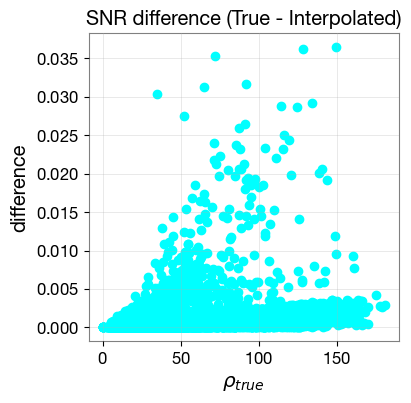

In [25]:
plt.figure(figsize=(4,4))
plt.plot(bilby_snr['optimal_snr_net'], abs(interp_snr['optimal_snr_net']-bilby_snr['optimal_snr_net']), 'o', color='cyan')
plt.xlabel(r"$\rho_{true}$")
plt.ylabel(r"difference")
plt.title(r"SNR difference (True - Interpolated)")
plt.grid(alpha=0.4)
plt.show()

* $\Delta (\text{SNR}_{\text{true}} - \text{SNR}_{\text{interpolated}})<0.04$ which is a good agreement between the two methods. 

### Pdet (probaility of detection) calculation

In [26]:
mass_1 = np.array([2,50.,100.,])
ratio = 1.
dl = 500
snr_dict = gwsnr.snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl)
# with snr threshold equal to 8
pdet_dict = gwsnr.probability_of_detection(snr_dict, snr_th=8, snr_th_net=8, type='bool')

In [27]:
print('snr: ', snr_dict["optimal_snr_net"])
print('pdet: ', pdet_dict["pdet_net"])

snr:  [  8.78159001 105.15382713   0.        ]
pdet:  [1 1 0]


### Changing the input arguments

What will change?
* Detectors: CE, ET.
* Minimum frequency: 10 Hz
* Maximum total mass: 500. Note that if this mass is above the allowed total mass for the given minimum frequency, i.e. the last stable orbit (LSO) frequency below the minimum frequency, then the maximum mass will be set to the maximum mass for the given minimum frequency.
* Waveform model: IMRPhenomXPHM
* multiprocessing_verbose: False, The progress bar won't be shown but the calculation will be faster.

In [28]:
# if snr_type = 'inner_product', interpolator will not be created
from gwsnr import GWSNR
gwsnr = GWSNR(
    npool = int(4), 
    mtot_min=2.,
    mtot_max=440.,  # highest total mass possible at 10Hz
    minimum_frequency = 10.,
    snr_type = 'inner_product', 
    #psds = {'CE':'CE_psd.txt', 'ET':'ET_B_psd.txt'}, # if you want to use your own psd
    ifos = ['CE', 'ET'],  # this will considet bilby's default psd of CE and ET
    multiprocessing_verbose=False,
)


Chosen GWSNR initialization parameters:

npool:  4
snr type:  inner_product
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  10.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=10.0): 369.97199706893525
detectors:  ['CE', 'ET1', 'ET2', 'ET3']
psds:  [PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ripple1/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/CE_psd.txt', asd_file='None'), PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ripple1/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/ET_D_psd.txt', asd_file='None'), PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ripple1/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/ET_D_psd.txt', asd_file='None'), PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ripple1/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/ET_D_psd.t

In [29]:
mass_1 = np.array([5, 10.,50.,100.])
ratio = np.array([1, 0.8,0.5,0.2])
gwsnr.snr(mass_1=mass_1, mass_2=mass_1*ratio)

solving SNR with inner product


{'CE': array([2148.90304551, 3418.3544206 , 9539.03962624,
        9480.46037205]),
 'ET1': array([149.37771668, 236.23429377, 662.6230723 , 639.92876964]),
 'ET2': array([ 426.53991017,  674.55412147, 1892.0839869 ,
        1827.28164531]),
 'ET3': array([ 474.63277116,  750.61086744, 2105.4186128 ,
        2033.30973335]),
 'optimal_snr_net': array([2246.622034  , 3572.02932848, 9972.21718955,
        9887.46400141])}

## SNR and Pdet with ANN (artificial neural network) model

* **Note:** as of 2024-02-16, the ANN model is only available for the IMRPhenomXPHM waveform model. This pre-trained model considers the spin precession of the compact objects. SNR with ANN is much faster than 'inner_product' method. The ANN model is trained with the data generated using `ler` package. The corresponding Pdet generated is more accurate (accuracy>99%) than it's absolute SNR. So users are advised to use the ANN model for Pdet calculation rather than SNR calculation.
  
* Users can train their own ANN model with the instructions in the documentation.

In [1]:
import numpy as np
from gwsnr import GWSNR

In [2]:
# innitialize the class for pdet calculation
gwsnr = GWSNR(mtot_resolution=100,
        ratio_resolution=20,snr_type='ann', waveform_approximant='IMRPhenomXPHM', pdet=True)


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Intel processor has trouble allocating memory when the data is huge. So, by default for IMRPhenomXPHM, duration_max = 64.0. Otherwise, set to some max value like duration_max = 600.0 (10 mins)
ANN model for L1 is loaded from gwsnr/ann directory.
ANN scaler for L1 is loaded from gwsnr/ann directory.
ANN error_adjustment for L1 is loaded from gwsnr/ann directory.
ANN model for H1 is loaded from gwsnr/ann directory.
ANN scaler for H1 is loaded from gwsnr/ann directory.
ANN error_adjustment for H1 is loaded from gwsnr/ann directory.
ANN model for V1 is loaded from gwsnr/ann directory.
ANN scaler for V1 is loaded from gwsnr/ann directory.
ANN error_adjustment for V1 is loaded from gwsnr/ann directory.
Interpolator will be generated for L1 detector at ./interpolator_pickle/L1/partialSNR_dict_10.pickle
Interpolator will be generated for H1 detector at ./interpolator_pickle/H1/partialSNR_dict_9.pickle
Interpolator will

interpolation for each mass_ratios: 100%|███████████████████████████| 20/20 [00:09<00:00,  2.05it/s]


Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/gwsnrtest/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/gwsnrtest/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/gwsnrtest/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/AdV_asd.txt')]


* compare pdet (bool)

In [3]:
nsamples = 10000
chirp_mass = np.linspace(5,60,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
param_dict = dict(
    mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5),
    mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5),
    # Fix luminosity distance
    luminosity_distance = 500*np.ones(nsamples),
    # Randomly sample everything else:
    theta_jn = np.random.uniform(0,2*np.pi, size=nsamples),
    ra = np.random.uniform(0,2*np.pi, size=nsamples), 
    dec = np.random.uniform(0,np.pi, size=nsamples), 
    psi = np.random.uniform(0,2*np.pi, size=nsamples),
    phase = np.random.uniform(0,2*np.pi, size=nsamples),
    geocent_time = 1246527224.169434*np.ones(nsamples),
    # spin zero
    a_1 = 0.0*np.ones(nsamples), 
    a_2 = 0.0*np.ones(nsamples), 
    tilt_1 = 0.0*np.ones(nsamples), 
    tilt_2 = 0.0*np.ones(nsamples), 
    phi_12 = 0.0*np.ones(nsamples), 
    phi_jl = 0.0*np.ones(nsamples),
)

In [4]:
# set the GW parameters
mass_1 = np.array([5, 10.,50.,200.])
ratio = np.array([1, 0.8,0.5,0.2])
param_dict = dict(
    mass_1 = mass_1,
    mass_2 = mass_1*ratio,
    luminosity_distance = np.array([1000, 2000, 3000, 4000]),
    theta_jn = np.array([0.1, 0.2, 0.3, 0.4]),
    ra = np.array([0.1, 0.2, 0.3, 0.4]), 
    dec = np.array([0.1, 0.2, 0.3, 0.4]), 
    psi = np.array([0.1, 0.2, 0.3, 0.4]),
    a_1 = np.array([0.1, 0.2, 0.3, 0.4]),
    a_2 = np.array([0.1, 0.2, 0.3, 0.4]),
    tilt_1 = np.array([0.1, 0.2, 0.3, 0.4]),
    tilt_2 = np.array([0.1, 0.2, 0.3, 0.4]),
    phi_12 = np.array([0.1, 0.2, 0.3, 0.4]),
    phi_jl = np.array([0.1, 0.2, 0.3, 0.4]),
    geocent_time = np.array([0.0, 0.0, 0.0, 0.0]),
    phase = np.array([0.0, 0.0, 0.0, 0.0]),
)

# pdet calculation with ANN
pdet_ann = gwsnr.snr(gw_param_dict=param_dict)
print(f'Probability of detection (with ANN): \n{pdet_ann}')

Probability of detection (with ANN): 
{'L1': array([0, 0, 1, 0]), 'H1': array([0, 0, 1, 0]), 'V1': array([0, 0, 0, 0]), 'pdet_net': array([1, 1, 1, 0])}


In [5]:
# pdet calculation with inner product
snr_bilby = gwsnr.compute_bilby_snr(gw_param_dict=param_dict)

# pdet calculation with inner product
pdet_bilby = gwsnr.probability_of_detection(snr_dict=snr_bilby, type='bool')
print(f'Probability of detection (with inner product SNR): \n{pdet_bilby}')

100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.93it/s]

Probability of detection (with inner product SNR): 
{'L1': array([1, 0, 1, 0]), 'H1': array([0, 0, 1, 0]), 'V1': array([0, 0, 0, 0]), 'pdet_net': array([1, 1, 1, 0])}


* compare the SNRs

In [80]:
# looking at the SNRs 
snr_ann = gwsnr.snr_with_ann(
    mass_1 = mass_1,
    mass_2 = mass_1*ratio,
    luminosity_distance = np.array([1000, 2000, 3000, 4000]),
    theta_jn = np.array([0.1, 0.2, 0.3, 0.4]),
    ra = np.array([0.1, 0.2, 0.3, 0.4]), 
    dec = np.array([0.1, 0.2, 0.3, 0.4]), 
    psi = np.array([0.1, 0.2, 0.3, 0.4]),
    a_1 = np.array([0.1, 0.2, 0.3, 0.4]),
    a_2 = np.array([0.1, 0.2, 0.3, 0.4]),
    tilt_1 = np.array([0.1, 0.2, 0.3, 0.4]),
    tilt_2 = np.array([0.1, 0.2, 0.3, 0.4]),
    phi_12 = np.array([0.1, 0.2, 0.3, 0.4]),
    phi_jl = np.array([0.1, 0.2, 0.3, 0.4]),
    geocent_time = np.array([0.0, 0.0, 0.0, 0.0]),
    phase = np.array([0.0, 0.0, 0.0, 0.0]),
)
print("SNR ANN : ", snr_ann["optimal_snr_net"])

# looking at the inner product SNRs
print("SNR inner product : ", snr_bilby["optimal_snr_net"])

SNR ANN :  [10.35015907  8.66277382 17.4468187   0.        ]
SNR inner product :  [11.41883925  9.31868266 17.87350892  0.        ]


* For comparision, let's have look at the interpolated spinless SNRs with IMRPhenomXPHM.

In [82]:
snr_interp = gwsnr.snr_with_interpolation(
    mass_1 = mass_1,
    mass_2 = mass_1*ratio,
    luminosity_distance = np.array([1000, 2000, 3000, 4000]),
    theta_jn = np.array([0.1, 0.2, 0.3, 0.4]),
    ra = np.array([0.1, 0.2, 0.3, 0.4]), 
    dec = np.array([0.1, 0.2, 0.3, 0.4]), 
    psi = np.array([0.1, 0.2, 0.3, 0.4]),
    geocent_time = np.array([0.0, 0.0, 0.0, 0.0]),
    phase = np.array([0.0, 0.0, 0.0, 0.0]),
)
print("SNR with interpolation =", snr_interp["optimal_snr_net"])
# effective spin
chi_eff = (mass_1 * a_1 * np.cos(tilt_1) + mass_2 * a_2 * np.cos(tilt_2)) / (mass_1 + mass_2)
print(f'effective spin : {chi_eff}')

SNR with interpolation = [11.33690677  9.10055852 16.50568851  0.        ]
effective spin : [0.09950042 0.19601332 0.28660095 0.3684244 ]


* spinless SNRs with IMRPhenomXPHM is more accurate when spin is small.

* **Note:** ANN is less accurate in low mass ratio region. The accuracy can be improved by increasing the number of training samples in the sparse region of the parameter space.

## Inner product assisted with JAX 

*  `ripple` is used to generate the waveform
   *  `ripple` available waveform : IMRPhenomXAS, IMRPhenomD (aligned spin), TaylorF2 with tidal effects, IMRPhenomD_NRTidalv2
*  It is further assisted with jax.jit+jax.vmap

In [1]:
import numpy as np
from gwsnr import GWSNR
# innitialize the class for pdet calculation
gwsnr = GWSNR(snr_type='inner_product_jax', waveform_approximant='IMRPhenomXAS', multiprocessing_verbose=False)


Initializing GWSNR class...

psds not given. Choosing bilby's default psds

Chosen GWSNR initialization parameters:

npool:  4
snr type:  inner_product_jax
waveform approximant:  IMRPhenomXAS
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/gwsnrtest/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/gwsnrtest/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/gwsnrtest/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/AdV_asd.txt')]


In [2]:
# set the GW parameters
mass_1 = np.array([5, 10.,50.,200.])
ratio = np.array([1, 0.8,0.5,0.2])
param_dict = dict(
    mass_1 = mass_1,
    mass_2 = mass_1*ratio,
    luminosity_distance = np.array([1000, 2000, 3000, 4000]),
    theta_jn = np.array([0.1, 0.2, 0.3, 0.4]),
    ra = np.array([0.1, 0.2, 0.3, 0.4]), 
    dec = np.array([0.1, 0.2, 0.3, 0.4]), 
    psi = np.array([0.1, 0.2, 0.3, 0.4]),
    a_1 = np.array([0.1, 0.2, 0.3, 0.4]),
    a_2 = np.array([0.1, 0.2, 0.3, 0.4]),
    geocent_time = np.array([0.0, 0.0, 0.0, 0.0]),
    phase = np.array([0.0, 0.0, 0.0, 0.0]),
)

# jax.jit functions are slow when run for the first time
snr_jax = gwsnr.snr(gw_param_dict=param_dict)
print("SNR (inner product JAX assisted) : ", snr_jax["optimal_snr_net"])

solving SNR with inner product JAX
SNR (inner product JAX assisted) :  [11.35195744  9.22144833 17.49777028  0.        ]


In [1]:
from gwsnr import GWSNR
import numpy as np

# initializing the GWSNR class with default parameters
gwsnr = GWSNR()


Initializing GWSNR class...

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_0.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_0.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_0.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  interpolation
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detect

In [3]:
detectors = gwsnr.detector_list.copy()
dectector_arr = np.array(detectors) * np.ones(
            (3, len(detectors)), dtype=object
        )

In [8]:
dectector_arr[0].tolist()

['L1', 'H1', 'V1']